# Laboratory practice 2.2: KNN classification

Here we will implement our first ML model based on the _very_ popular KNN algorithm. We will use the preprocessed data from the previous practice, `SimData.dat`. The data should be properly cleaned already, and we should have available the two resulting files `train.dat` and `test.dat` with the training and testing data, respectively. Therefore, we will not need to do the preprocessing here, which is why we will (almost) jump to implementing KNN and applying it to the data.

In [12]:
# Load the modules you'll need later

# Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Add Lab_2_2_kNN.py to the path
import sys
sys.path.append('../src')

# Import the functions from the solution
from Lab_2_2_kNN import knn, plot_probability_histograms, plot_roc_curve, evaluate_classification_metrics, plot_2Dmodel_predictions, plot_calibration_curve

## 1. Prepare the Dataset

This part of the process you already did in the previous practice! You can reuse everything here. Moreover, if you saved the train/test split into `train.dat` and `test.dat`, you can use them here!

In [13]:
# Load the train and test data you generated (use the name "train_df" and "test_df")
train_df = pd.read_csv('train.dat', sep="\t")
test_df = pd.read_csv('test.dat', sep="\t")
# Convert output variable to factor
train_df['Y'] = train_df['Y'].astype("category")
test_df['Y'] = test_df['Y'].astype("category")

In [31]:
# Define input and output variables, and store X_train, X_test, y_train and y_test matrices
input_vars = ['X1','X2']
target_var = 'Y'

X_train = train_df[input_vars]
y_train = train_df[target_var]
X_test = test_df[input_vars]
y_test = test_df[target_var]

## 2. Training of Machine Learning models

#### Minkowski Distance

<center>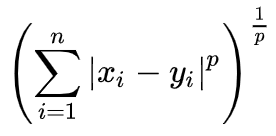</center>

#### k-Nearest Neighbors Model

- [K-Nearest Neighbours](https://scikit-learn.org/stable/modules/neighbors.html#classification)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [15]:
# Inputs of the model. Change accordingly to perform feature selection
INPUTS_KNN = input_vars

# Define hyperparameters of the model
k = 31 # Number of nearest neighbors
p = 2 # Order of Minkowski distance (what distance is this?)

# Create a model object
knn_fit = knn()
print(knn_fit)

kNN model (k=None, p=None)


In [16]:
# Train model
knn_fit.fit(X_train[INPUTS_KNN].values, y_train.values, k=k, p=p)
print("kNN Trained")
print(knn_fit)
"""y_train = y_train.fillna('NO')
y_train = y_train.replace({'YES': 1, 'NO': 0}).astype(int)
print(y_train.unique())  # Ver los valores únicos en y_train"""


kNN Trained
kNN model (k=31, p=2)


"y_train = y_train.fillna('NO')\ny_train = y_train.replace({'YES': 1, 'NO': 0}).astype(int)\nprint(y_train.unique())  # Ver los valores únicos en y_train"

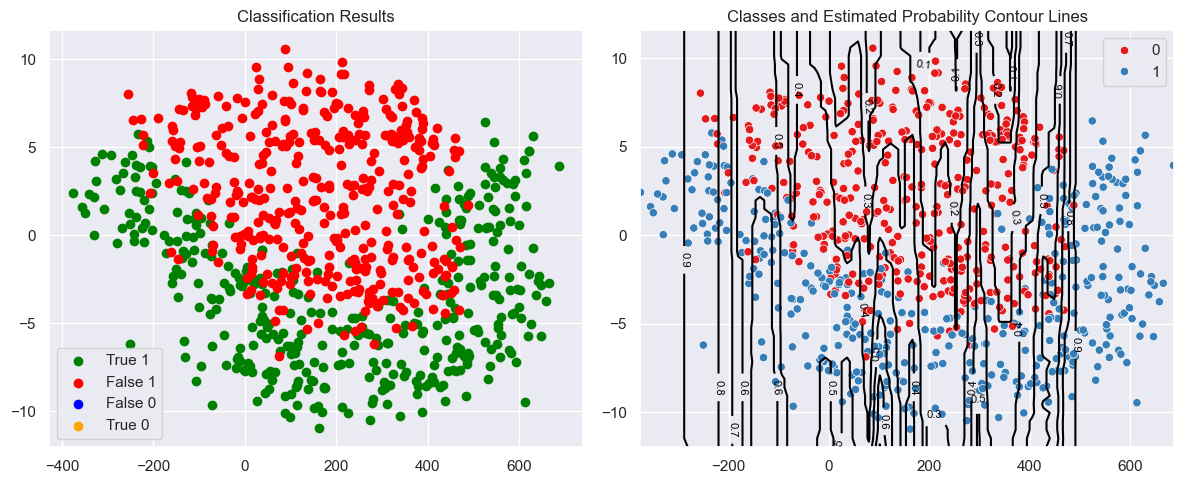

In [17]:
model_predictions = plot_2Dmodel_predictions(X_train[INPUTS_KNN].values, y_train.values, knn_fit, 50)

In [18]:
# Obtain train performance metrics
evaluate_classification_metrics(y_train, knn_fit.predict(X_train[INPUTS_KNN].values), 1)

{'Confusion Matrix': [np.int64(0), np.int64(401), np.int64(0), np.int64(395)],
 'Accuracy': np.float64(0.4962311557788945),
 'Precision': np.float64(0.4962311557788945),
 'Recall': np.float64(1.0),
 'Specificity': np.float64(0.0),
 'F1 Score': np.float64(0.6633081444164567)}

In [19]:
# Obtain test performance metrics
evaluate_classification_metrics(y_test, knn_fit.predict(X_test[INPUTS_KNN].values),  'YES')

{'Confusion Matrix': [np.int64(200), np.int64(0), np.int64(0), np.int64(0)],
 'Accuracy': np.float64(1.0),
 'Precision': 0,
 'Recall': 0,
 'Specificity': np.float64(1.0),
 'F1 Score': 0}

In [20]:
probs = knn_fit.predict_proba(X_train.values)

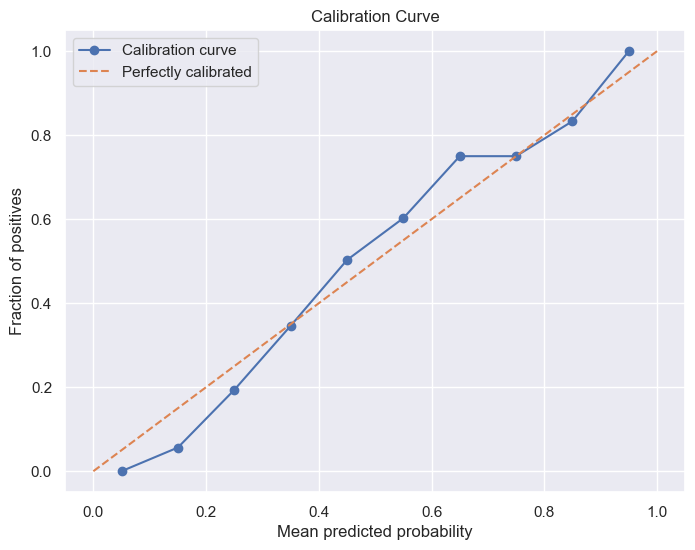

In [32]:
def plot_calibration_curve(y_true, y_probs, positive_label, n_bins=10):
    """
    Plot a calibration curve to evaluate the accuracy of predicted probabilities.

    This function creates a plot that compares the mean predicted probabilities
    in each bin with the fraction of positives (true outcomes) in that bin.
    This helps assess how well the probabilities are calibrated.

    Args:
        y_true (array-like): True labels of the data. Can be binary or categorical.
        y_probs (array-like): Predicted probabilities for the positive class (positive_label).
                            Expected values are in the range [0, 1].
        positive_label (int or str): The label that is considered the positive class.
                                    This is used to map categorical labels to binary outcomes.
        n_bins (int, optional): Number of bins to use for grouping predicted probabilities.
                                Defaults to 10. Bins are equally spaced in the range [0, 1].

    Returns:
        dict: A dictionary with the following keys:
            - "bin_centers": Array of the center values of each bin.
            - "true_proportions": Array of the fraction of positives in each bin

    """
    y_true_mapped = np.array([1 if label == positive_label else 0 for label in y_true])

    # Initialize bins and counts
    bin_counts = [0] * n_bins
    true_counts = [0] * n_bins
    bin_centers = [(i + 0.5) / n_bins for i in range(n_bins)]

    # Assign probabilities to bins
    for i in range(len(y_true_mapped)):
        true = y_true_mapped[i]
        prob = y_probs[i]
        bin_index = int(prob * n_bins)
        if bin_index == n_bins:  # Handle the edge case where prob == 1
            bin_index = n_bins - 1
        bin_counts[bin_index] += 1
        true_counts[bin_index] += true

    # Calculate true proportions
    true_proportions = [
        true_counts[i] / bin_counts[i] if bin_counts[i] > 0 else 0
        for i in range(n_bins)]

    # Plot the calibration curve
    plt.figure(figsize=(8, 6))
    plt.plot(bin_centers, true_proportions, marker='o', linestyle='-', label='Calibration curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Curve')
    plt.legend()
    plt.show()

    return {"bin_centers": bin_centers, "true_proportions": true_proportions}
calibration_curve = plot_calibration_curve(y_train.values, probs[:,1], 1)

In [34]:
probability_histograms = plot_probability_histograms(y_train.values, probs[:,1], 1)

TypeError: argument of type 'int' is not iterable

In [35]:
roc_curve = plot_roc_curve(y_train.values, probs[:,1], 1)

TypeError: argument of type 'int' is not iterable